In [177]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from matplotlib import pyplot as plt
import cv2
import os
import csv
from tqdm import tqdm

import tensorflow as tf
from tensorflow import shape,math
from tensorflow.keras import Input,layers,Model
from tensorflow.keras.losses import mse,binary_crossentropy
from tensorflow.keras.utils import plot_model

import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')

# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [178]:
import os
import pandas as pd
import numpy as np

output_dir = os.path.join(".", "output")  # Path to the output directory
subdirs = [f.path for f in os.scandir(output_dir) if f.is_dir()]
subdirs.sort()

# Create an empty 3D array to store the combined data
combined_arr = np.empty((len(subdirs), 999, 10))

# Loop through each subdirectory and load the CSV files
for i, subdir in enumerate(subdirs):
    action_filename = os.path.join(subdir, "action.csv")
    obs_filename = os.path.join(subdir, "obs.csv")

    # Load the action and obs CSV files
    action_df = pd.read_csv(action_filename)
    obs_df = pd.read_csv(obs_filename)

    # Concatenate the DataFrames horizontally
    combined_data = pd.concat([action_df, obs_df], axis=1)

    # Convert combined_data to a 3D array and assign it to combined_arr
    combined_arr[i] = np.reshape(combined_data.values, (999, 10))

# Print the shape of combined_arr
print(combined_arr.shape)


(10000, 999, 10)


In [179]:
flattened_arr = combined_arr.reshape(10000, 9990)

In [223]:
flattened_arr.shape

(10000, 9990)

In [153]:
import torch

combined_df = np.array(combined_arr)
combined_tensor = torch.from_numpy(combined_df)
flattened_tensor = combined_tensor.flatten(start_dim=1)

In [158]:
# Rename dimensions to 'Seed' and 'Data'
flattened_tensor.names = ("Seed", "Data")

# Now flattened_tensor will have dimensions named 'Seed' and 'Data'
print(flattened_tensor.shape)  # Output: torch.Size([10000, 9990])
print(flattened_tensor)

torch.Size([10000, 9990])
tensor([[ 1.0000, -0.4887, -0.1252,  ...,  0.0083, -0.0401, -0.0155],
        [ 1.0000,  0.2914, -0.1100,  ..., -0.0194, -0.0593, -0.0475],
        [-0.4827, -0.0642,  0.0884,  ...,  0.0491, -0.0721,  0.0813],
        ...,
        [ 0.2111,  0.1188,  0.0484,  ...,  0.0955, -0.0528,  0.0854],
        [ 0.9419,  0.2745, -0.0977,  ...,  0.0782, -0.0866, -0.0358],
        [-0.7274, -0.2809, -0.0156,  ..., -0.0464, -0.0701,  0.0366]],
       dtype=torch.float64, names=('Seed', 'Data'))


In [166]:
len(flattened_tensor)

10000

In [170]:
# Y Plot
for i in range(1,len(flattened_tensor)):
    plt.figure(figsize=(15,5))
    plt.plot(flattened_tensor['Data'], flattened_tensor['Y{}'.format(i)], c='black')
    plt.plot([0, flattened_tensor.shape[0]], [np.percentile(flattened_tensor['Y{}'.format(i)], 25), np.percentile(flattened_tensor['Y{}'.format(i)], 25)],c='red')
    plt.plot([0, flattened_tensor.shape[0]], [np.percentile(flattened_tensor['Y{}'.format(i)], 75), np.percentile(flattened_tensor['Y{}'.format(i)], 75)],c='blue')
    plt.title('Y{}'.format(i))
    plt.show()

IndexError: too many indices for tensor of dimension 2

<Figure size 1500x500 with 0 Axes>

In [121]:
import os
import pandas as pd
import numpy as np

output_dir = os.path.join(".", "output")  # Path to the output directory
subdirs = [f.path for f in os.scandir(output_dir) if f.is_dir()]
subdirs.sort()

# Create an empty 3D array to store the combined data
combined_arr = np.empty((len(subdirs), 1000, 10))

# Loop through each subdirectory and load the CSV files
for i, subdir in enumerate(subdirs):
    action_filename = os.path.join(subdir, "action.csv")
    obs_filename = os.path.join(subdir, "obs.csv")

    # Load the action and obs CSV files
    action_df = pd.read_csv(action_filename,  header=None)
    obs_df = pd.read_csv(obs_filename,  header=None)

    # Concatenate the DataFrames horizontally
    combined_data = pd.concat([action_df, obs_df], axis=1)

    # Convert combined_data to a 3D array and assign it to combined_arr
    combined_arr[i-1] = np.reshape(combined_data.values, (1000, 10))

# Print the shape of combined_arr
print(combined_arr.shape)


(10000, 1000, 10)


In [122]:
combined_df = np.array(combined_arr)

In [123]:
combined_arr[0,0,:]

array([ 2.01561330e-01,  3.12052670e-04, -7.71057430e-02,  9.93219768e-02,
       -4.72605934e-02, -4.67853317e-03,  3.17784149e-01, -2.76567454e-01,
        4.65930404e-01, -3.84762646e-01])

In [3]:
# import os
# import pandas as pd
# from tqdm import tqdm  # Import tqdm

# output_dir = os.path.join(".", "output")  # Path to the output directory
# subdirs = [f.path for f in os.scandir(output_dir) if f.is_dir()]
# combined_df = pd.DataFrame()

# # Create a tqdm progress bar
# pbar = tqdm(subdirs, desc="Processing subdirectories", unit="subdir")

# for subdir in pbar:
#     action_filename = os.path.join(subdir, "action.csv")
#     obs_filename = os.path.join(subdir, "obs.csv")
#     action_df = pd.read_csv(action_filename)
#     obs_df = pd.read_csv(obs_filename)
#     combined_data = pd.concat([action_df, obs_df], axis=1)
#     if combined_data.shape == (999,10):
#         combined_df = pd.concat([combined_df, combined_data], ignore_index=True)
#     else:
#         print("fail : ", subdir)

#     # Update the progress bar
#     pbar.set_postfix({"Processed subdirectories": subdir})

# # Close the progress bar
# pbar.close()



In [180]:
import torch

# Convert combined_arr to PyTorch Tensor
combined_tensor = torch.from_numpy(combined_arr)

# Print the shape of combined_tensor
print(combined_tensor.shape)

torch.Size([10000, 999, 10])


# VAE code -2

In [213]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import random_split

# Assuming combined_tensor is your data
# Convert the data to float32
dataset = TensorDataset(combined_tensor.float())

# Define the data loader
batch_size = 256  # adjust as necessary

# Split data into train, validation, and test
train_size = int(0.7 * len(dataset))  # 70% for training
valid_size = int(0.15 * len(dataset))  # 15% for validation
test_size = len(dataset) - train_size - valid_size  # 15% for testing

train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Hyperparameters
input_shape = combined_tensor.shape[1] * combined_tensor.shape[2]  # modify this to match your data
hidden_dim1 = 128  # modify as needed
hidden_dim2 = 256  # modify as needed
hidden_dim3 = 512  # modify as needed
latent_dim = 2  # modify as needed
lr = 1e-3  # learning rate


class VAE(nn.Module):
    def __init__(self, input_shape, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_shape, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim3),
            nn.ReLU(),
            nn.Linear(hidden_dim3, latent_dim * 2)  # mean and variance
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim3),
            nn.ReLU(),
            nn.Linear(hidden_dim3, input_shape),
#             nn.Sigmoid()      ## 시그모이드를 뺴야됨. 왜냐면 애초데이터가 0과 1사이가 아니기때문
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var / 2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu, log_var = h.chunk(2, dim=1)
        z = self.reparameterize(mu, log_var)
        x_reconstructed = self.decoder(z)
        return x_reconstructed, mu, log_var
    
# Model, optimizer, and loss function
model = VAE(input_shape, hidden_dim1, latent_dim)

optimizer = optim.NAdam(model.parameters(), lr=lr)
loss_fn = nn.MSELoss() #MSE로 바꿔보자.

def train(epoch, model, optimizer, loss_fn, train_loader):
    model.train()
    train_loss = 0
    total_recon_loss = 0
    total_kl_div = 0
    for i, batch in enumerate(train_loader):  # using train_loader instead of dataloader
        batch_data = batch[0]  # get the data from the batch

        optimizer.zero_grad()

        # Flatten the data
        batch_data = batch_data.view(batch_data.size(0), -1)

        reconstructed_batch, mu, log_var = model(batch_data)

        # Loss: reconstruction loss + KL divergence
        recon_loss = loss_fn(reconstructed_batch, batch_data)
        kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        loss = recon_loss + kl_divergence

        loss.backward()
        train_loss += loss.item()
        total_recon_loss += recon_loss.item()
        total_kl_div += kl_divergence.item()
        optimizer.step()

    avg_loss = train_loss / len(train_loader.dataset)
    avg_recon_loss = total_recon_loss / len(train_loader.dataset)
    avg_kl_div = total_kl_div / len(train_loader.dataset)
    print(f'====> Epoch: {epoch} Average loss: {avg_loss}, Recon Loss: {avg_recon_loss}, KL Div: {avg_kl_div}')

    return avg_loss, avg_recon_loss, avg_kl_div


In [214]:
import matplotlib.pyplot as plt

# Lists to store losses for each epoch
avg_losses = []
avg_recon_losses = []
avg_kl_divs = []

# Training
n_epochs = 50  # modify as needed
for epoch in range(1, n_epochs + 1):
    avg_loss, avg_recon_loss, avg_kl_div = train(epoch, model, optimizer, loss_fn, train_loader)
    avg_losses.append(avg_loss)
    avg_recon_losses.append(avg_recon_loss)
    avg_kl_divs.append(avg_kl_div)

# Plot the losses
plt.figure(figsize=(7,5))
plt.plot(avg_losses, label='Average Loss')
plt.plot(avg_recon_losses, label='Reconstruction Loss')
plt.plot(avg_kl_divs, label='KL Divergence')
plt.title('Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


====> Epoch: 1 Average loss: nan, Recon Loss: nan, KL Div: nan
====> Epoch: 2 Average loss: nan, Recon Loss: nan, KL Div: nan
====> Epoch: 3 Average loss: nan, Recon Loss: nan, KL Div: nan
====> Epoch: 4 Average loss: nan, Recon Loss: nan, KL Div: nan


KeyboardInterrupt: 

# VAE code -1

====> Epoch: 1 Average loss: 0.014801270280565534, Recon Loss: 0.011291185174669538, KL Div: 0.003510085212332862
====> Epoch: 2 Average loss: 0.011986114025115967, Recon Loss: 0.011288004330226354, KL Div: 0.0006981096693447658
====> Epoch: 3 Average loss: 0.011559778213500977, Recon Loss: 0.011286637033735003, KL Div: 0.0002731410733291081
====> Epoch: 4 Average loss: 0.011436262505395072, Recon Loss: 0.011283032144818987, KL Div: 0.00015323037760598318
====> Epoch: 5 Average loss: 0.011385258436203003, Recon Loss: 0.011279069321496147, KL Div: 0.00010618910193443298
====> Epoch: 6 Average loss: 0.011356723615101405, Recon Loss: 0.011275482075554984, KL Div: 8.12414756843022e-05
====> Epoch: 7 Average loss: 0.011337130171912057, Recon Loss: 0.011271170275551932, KL Div: 6.595984101295471e-05
====> Epoch: 8 Average loss: 0.011323153597967966, Recon Loss: 0.011267270190375192, KL Div: 5.588327986853463e-05
====> Epoch: 9 Average loss: 0.011311734574181692, Recon Loss: 0.011263236420495

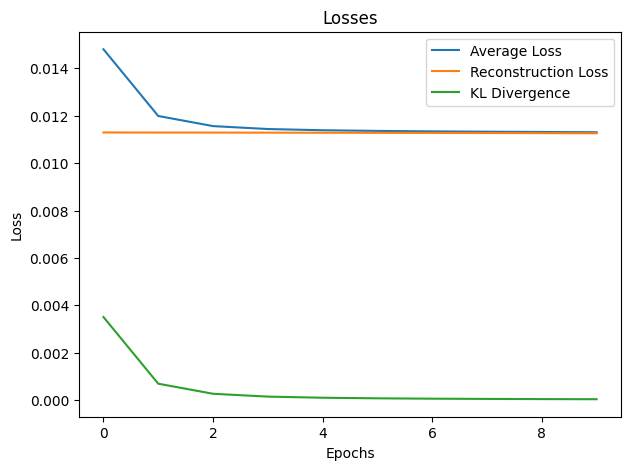

In [233]:
class Encoder(nn.Module):
    def __init__(self, input_shape, hidden_dim1, hidden_dim2, hidden_dim3, latent_dim):
        super(Encoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_shape, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim3),
            nn.ReLU(),
            nn.Linear(hidden_dim3, latent_dim * 2)  # mean and variance
        )

    def forward(self, x):
        h = self.encoder(x)
        mu, log_var = h.chunk(2, dim=1)
        return mu, log_var


class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_shape):
        super(Decoder, self).__init__()

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim3),
            nn.ReLU(),
            nn.Linear(hidden_dim3, output_shape),
        )

    def forward(self, z):
        x_reconstructed = self.decoder(z)
        return x_reconstructed


class VAE(nn.Module):
    def __init__(self, input_shape, hidden_dim1, hidden_dim2, hidden_dim3, latent_dim):
        super(VAE, self).__init__()

        self.encoder = Encoder(input_shape, hidden_dim1, hidden_dim2, hidden_dim3, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim1, hidden_dim2, hidden_dim3, input_shape)

    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var / 2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        x_reconstructed = self.decoder(z)
        return x_reconstructed, mu, log_var

    
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import random_split

# Assuming combined_tensor is your data
# Convert the data to float32
dataset = TensorDataset(combined_tensor.float())

# Define the data loader
batch_size = 256  # adjust as necessary

# Split data into train, validation, and test
train_size = int(0.7 * len(dataset))  # 70% for training
valid_size = int(0.15 * len(dataset))  # 15% for validation
test_size = len(dataset) - train_size - valid_size  # 15% for testing

train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Hyperparameters
input_shape = combined_tensor.shape[1] * combined_tensor.shape[2]  # modify this to match your data
hidden_dim1 = 128  # modify as needed
hidden_dim2 = 256  # modify as needed
hidden_dim3 = 512  # modify as needed
latent_dim = 2  # modify as needed
lr = 1e-5  # learning rate
n_epochs = 10  # modify as needed
    
# Model, optimizer, and loss function
model = VAE(input_shape, hidden_dim1, hidden_dim2, hidden_dim3, latent_dim)

optimizer = optim.RAdam(model.parameters(), lr=lr)  # Make sure you're using the correct optimizer
loss_fn = nn.MSELoss()  # And the correct loss function


def train(epoch, model, optimizer, loss_fn, train_loader):
    model.train()
    train_loss = 0
    total_recon_loss = 0
    total_kl_div = 0
    for i, batch in enumerate(train_loader):  # using train_loader instead of dataloader
        batch_data = batch[0]  # get the data from the batch

        optimizer.zero_grad()

        # Flatten the data
        batch_data = batch_data.view(batch_data.size(0), -1)

        reconstructed_batch, mu, log_var = model(batch_data)

        # Loss: reconstruction loss + KL divergence
        recon_loss = loss_fn(reconstructed_batch, batch_data)
        kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        loss = recon_loss + kl_divergence

        loss.backward()
        train_loss += loss.item()
        total_recon_loss += recon_loss.item()
        total_kl_div += kl_divergence.item()
        optimizer.step()

    avg_loss = train_loss / len(train_loader.dataset)
    avg_recon_loss = total_recon_loss / len(train_loader.dataset)
    avg_kl_div = total_kl_div / len(train_loader.dataset)
    print(f'====> Epoch: {epoch} Average loss: {avg_loss}, Recon Loss: {avg_recon_loss}, KL Div: {avg_kl_div}')

    return avg_loss, avg_recon_loss, avg_kl_div

    
import matplotlib.pyplot as plt

# Lists to store losses for each epoch
avg_losses = []
avg_recon_losses = []
avg_kl_divs = []

# Training
for epoch in range(1, n_epochs + 1):
    avg_loss, avg_recon_loss, avg_kl_div = train(epoch, model, optimizer, loss_fn, train_loader)
    avg_losses.append(avg_loss)
    avg_recon_losses.append(avg_recon_loss)
    avg_kl_divs.append(avg_kl_div)

# Plot the losses
plt.figure(figsize=(7,5))
plt.plot(avg_losses, label='Average Loss')
plt.plot(avg_recon_losses, label='Reconstruction Loss')
plt.plot(avg_kl_divs, label='KL Divergence')
plt.title('Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [234]:
def evaluate(model, loss_fn, dataloader):
    model.eval()
    loss = 0
    total_recon_loss = 0
    total_kl_div = 0
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            batch_data = batch[0]  # get the data from the batch

            # Flatten the data
            batch_data = batch_data.view(batch_data.size(0), -1)

            reconstructed_batch, mu, log_var = model(batch_data)

            # Loss: reconstruction loss + KL divergence
            recon_loss = loss_fn(reconstructed_batch, batch_data)
            kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            loss += recon_loss + kl_divergence
            total_recon_loss += recon_loss.item()
            total_kl_div += kl_divergence.item()

    avg_loss = loss / len(dataloader.dataset)
    avg_recon_loss = total_recon_loss / len(dataloader.dataset)
    avg_kl_div = total_kl_div / len(dataloader.dataset)

    return avg_loss, avg_recon_loss, avg_kl_div

In [235]:
evaluate(model, loss_fn, test_loader)

(tensor(0.0113), 0.011253700256347657, 3.788161277770996e-05)